# Import required libraries :

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , Input
from tensorflow.keras.optimizers import Adam
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold , train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , roc_curve , roc_auc_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [ ]:
print(tf.__version__)

2.7.0


# Import data :

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
df=pd.read_csv("/content/drive/MyDrive/toxcast/final_toxcast.csv")

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,label
0,0.975099,0.013842,5.438167e-01,5.346966e-01,6.893569e-07,0.212674,0.117444,2.509948e-11,8.947108e-01,5.856109e-17,0.000001,2.391450e-11,6.506469e-01,0.861796,2.155533e-14,0.935064,0.187764,0.058719,0.080838,0.570019,0.355170,0.233006,0.061316,0.124047,9.938587e-22,0.142492,0.062963,0.358207,4.829930e-15,5.695163e-08,0.000000,0.008722,5.761429e-21,3.608753e-15,0.145980,9.763762e-01,0.646059,9.054986e-08,4.609784e-10,0.157072,...,0.164929,1.317445e-17,2.111644e-16,1.168159e-09,9.095146e-01,6.246014e-10,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,1.00000,1.000000,0.009089,0.168363,8.265423e-11,0.156346,0.021135,2.388156e-20,0.000000,8.336725e-25,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.307979,0.0
1,0.996567,0.006574,9.228296e-01,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.258417e-11,5.856109e-17,0.000001,9.366795e-01,6.734474e-01,0.020161,9.993903e-01,0.996343,0.877467,0.018610,0.422625,0.788891,0.995659,0.262737,0.061316,0.124047,9.938587e-22,0.142492,0.062963,0.034723,4.829930e-15,5.695163e-08,0.000000,0.476636,5.761429e-21,9.981332e-01,0.145980,1.735567e-22,0.059983,9.054986e-08,4.609784e-10,0.157072,...,0.164929,1.317445e-17,2.111644e-16,1.168159e-09,3.259236e-22,6.246014e-10,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.16764,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.021135,2.388156e-20,0.000000,8.336725e-25,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.673632,0.0
2,0.627583,0.010335,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.323450,8.085811e-01,8.568377e-01,5.856109e-17,0.000001,5.109841e-01,7.522456e-13,0.294906,9.965627e-01,0.970667,0.353588,0.266267,0.145518,0.266310,0.899643,0.110802,0.061316,0.124047,9.999521e-01,0.918732,0.937037,0.034723,4.829930e-15,5.695163e-08,0.895427,0.344811,5.761429e-21,3.608753e-15,0.842364,1.735567e-22,0.312257,9.054986e-08,4.609784e-10,0.157072,...,0.164929,1.317445e-17,2.111644e-16,1.168159e-09,3.259236e-22,6.246014e-10,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.16764,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.021135,2.388156e-20,0.945901,8.336725e-25,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.591018,0.0
3,0.975099,0.013568,5.438167e-01,5.346966e-01,6.893569e-07,0.212674,0.135223,2.509948e-11,8.947108e-01,5.856109e-17,0.000001,2.391450e-11,4.053488e-01,0.861796,2.155533e-14,0.867973,0.157279,0.058781,0.261467,0.570386,0.375367,0.096345,0.707279,0.193672,9.938587e-22,0.142492,0.062963,0.358207,4.829930e-15,5.695163e-08,0.000000,0.155431,5.761429e-21,3.608753e-15,0.145980,9.763762e-01,0.646059,9.054986e-08,4.609784e-10,0.157072,...,0.164929,1.317445e-17,2.111644e-16,1.168159e-09,3.259236e-22,6.246014e-10,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,1.00000,1.000000,0.009089,0.168363,8.265423e-11,0.156346,0.021135,2.388156e-20,0.000000,8.336725e-25,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.187246,0.0
4,0.975099,0.013472,5.438167e-01,5.346966e-01,6.893569e-07,0.405153,0.019674,2.509948e-11,8.947108e-01,5.856109e-17,0.000001,2.391450e-11,3.705617e-01,0.861796,2.155533e-14,0.867973,0.157279,0.057693,0.956755,0.571313,0.112547,0.107062,0.436077,0.193672,9.938587e-22,0.142492,0.0

In [5]:
df.shape

(7831, 136)

In [6]:
y=df['label']
df_x=df.drop(['label'],axis=1)



### Checking the distribution of labels :

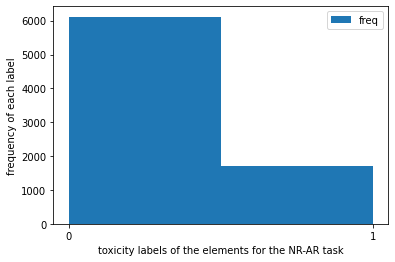

In [7]:
plt.hist(y,label='freq',bins=2)
plt.legend(loc="upper right")
plt.xticks(range(0,2))
plt.xlabel('toxicity labels of the elements for the NR-AR task')
plt.ylabel('frequency of each label')
plt.show()

In [8]:
y.value_counts()

0.0    6116
1.0    1715
Name: label, dtype: int64

Regarding the imbalanced label set, we are prone to overfitting. So, to mitigate this issue, we will use K-fold cross validation.

---------------
# Neural Network
---------------

## Data Splitting for Neural Network model




In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=0.1, random_state=23)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7047, 135)
(7047,)
(784, 135)
(784,)


In [11]:
y_train.value_counts()

0.0    5499
1.0    1548
Name: label, dtype: int64

# Building and Training our Neural Network architucture :

In [12]:
def reg_four_layer_model_config(n1=64,n2=32,n3=16,lnd=0.001):
  input = Input(x_train.shape[1])
  model= Dense(n1, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lnd))(input)
  model =Dropout(0.3,name='D_O_of_layer1')(model)
  model=Dense(n2, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lnd))(model)
  model =Dropout(0.2,name='D_O_of_layer2')(model)
  model=Dense(n3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lnd))(model)
  model =Dropout(0.1,name='D_O_of_layer3')(model)
  output=Dense(1, activation='sigmoid')(model)
  model=Model(inputs=input,outputs=output)
  return model

In [13]:
def comp(model,lr=0.05):
  acc=tf.keras.metrics.BinaryAccuracy()
  model.compile(optimizer=Adam(learning_rate=lr),loss='binary_crossentropy', metrics=acc)
  return model

In [14]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(df['val_loss'])
    axs[0].plot(df['loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['validation loss','training loss'], loc='upper right')
    axs[0].set_title('Loss of train/validation sets during Epochs')
    axs[0].set_ylim(0,1)
    axs[1].plot(df['val_binary_accuracy'])
    axs[1].plot(df['binary_accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend(['validation accuracy','training accuracy'], loc='lower right')
    axs[1].set_title('Accuracy of train/validation sets during Epochs')
    axs[1].set_ylim(0.5,1)
    plt.show()

Because our data is imbalanced, we'll use stratified k-fold cross validation

In [15]:
strat_kfold = StratifiedKFold(n_splits=10)
fold_num = 1
acc_per_fold = []
loss_per_fold = []
history_per_fold= []
for train_index, test_index in strat_kfold.split(x_train, y_train):
     model=reg_four_layer_model_config()
     comp(model,lr=0.001)

     print('------------------------------------------------------------------------')
     print(f'Training for fold {fold_num} ...')

     history = model.fit(x_train.iloc[train_index], y_train.iloc[train_index], batch_size=64, validation_data=(x_train.iloc[test_index], y_train.iloc[test_index]),epochs=10, verbose=1)
     history_per_fold.append(history)
     scores = model.evaluate(x_train.iloc[test_index], y_train.iloc[test_index] , verbose=0)
     print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
     acc_per_fold.append(scores[1] * 100)
     loss_per_fold.append(scores[0])
     fold_num = fold_num + 1



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
100/100 [==============================] - 2s 7ms/step - loss: 0.6594 - binary_accuracy: 0.7774 - val_loss: 0.5606 - val_binary_accuracy: 0.7773
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5414 - binary_accuracy: 0.7939 - val_loss: 0.4876 - val_binary_accuracy: 0.8142
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5050 - binary_accuracy: 0.8054 - val_loss: 0.4631 - val_binary_accuracy: 0.8270
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4781 - binary_accuracy: 0.8136 - val_loss: 0.4396 - val_binary_accuracy: 0.8241
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4580 - binary_accuracy: 0.8248 - val_loss: 0.4368 - val_binary_accuracy: 0.8284
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4485 - binary_accuracy: 0.8226 - val_loss: 0.42

In [16]:
# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} +- {np.std(acc_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4150561988353729 - Accuracy: 83.1205666065216%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4246012270450592 - Accuracy: 83.97163152694702%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.43100255727767944 - Accuracy: 82.83687829971313%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.43526971340179443 - Accuracy: 81.13475441932678%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.4033149778842926 - Accuracy: 84.82269644737244%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.4120846092700958 - Accuracy: 83.26241374015808%
-----------------------------------------------------------------------

--------------------FOLD 1 --------------------


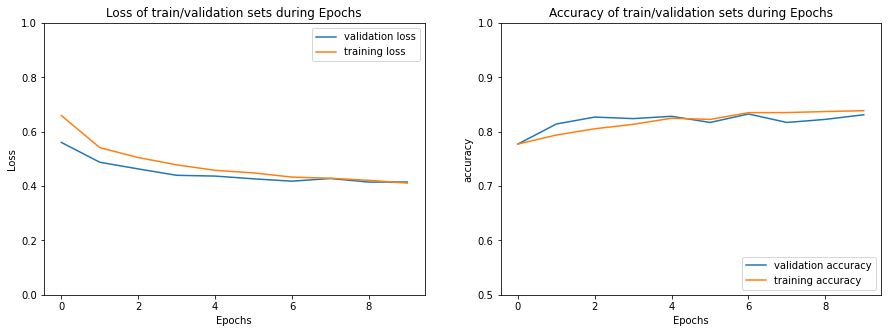

--------------------FOLD 2 --------------------


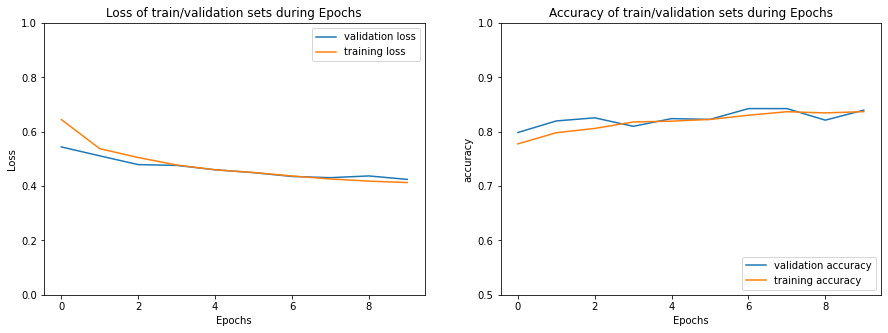

--------------------FOLD 3 --------------------


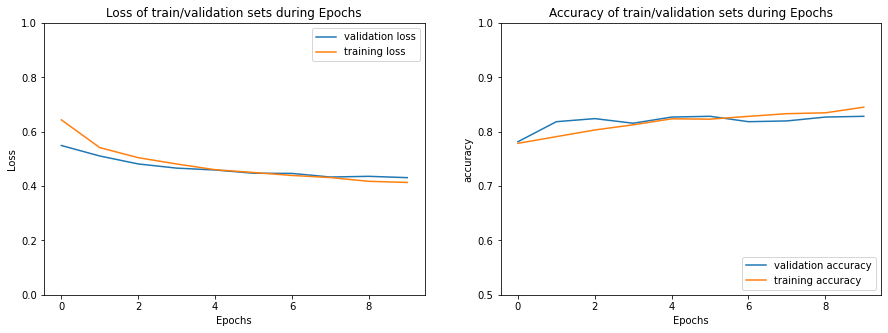

--------------------FOLD 4 --------------------


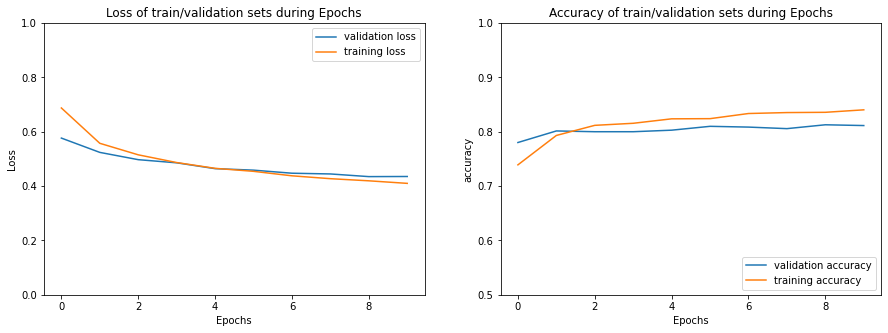

--------------------FOLD 5 --------------------


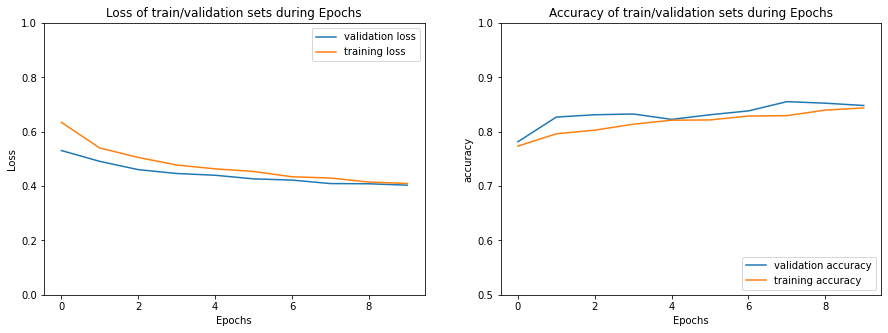

--------------------FOLD 6 --------------------


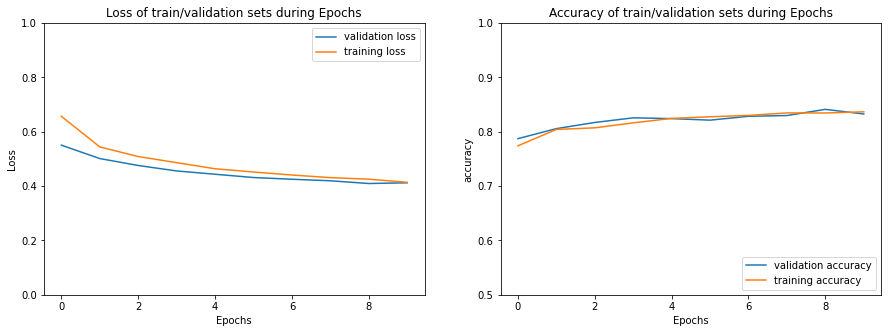

--------------------FOLD 7 --------------------


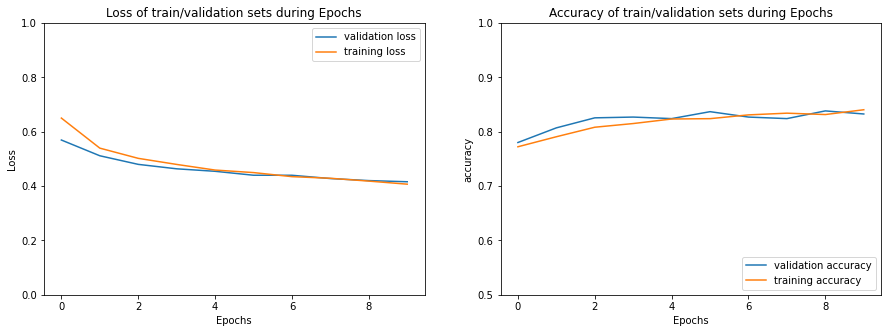

--------------------FOLD 8 --------------------


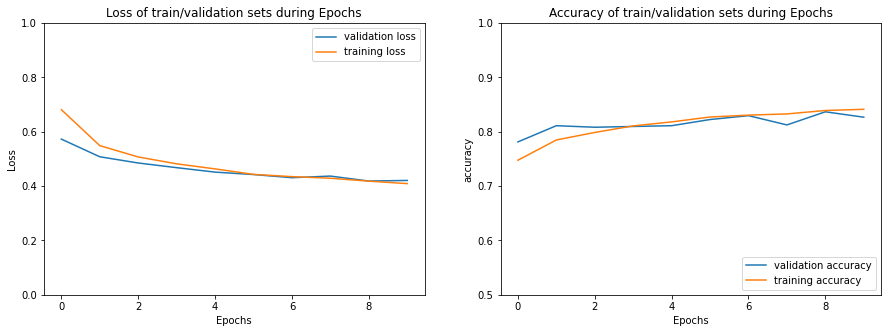

--------------------FOLD 9 --------------------


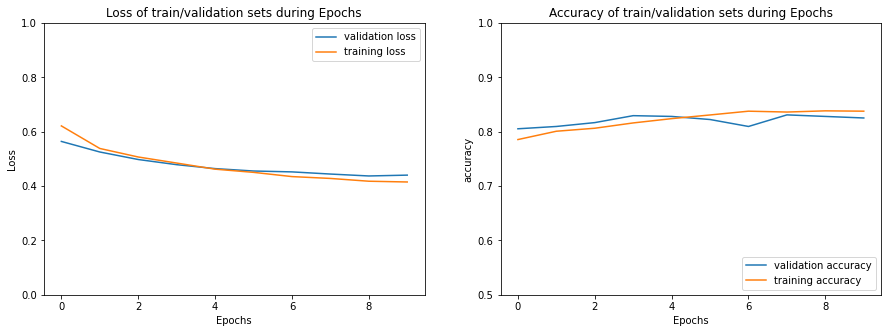

--------------------FOLD 10 --------------------


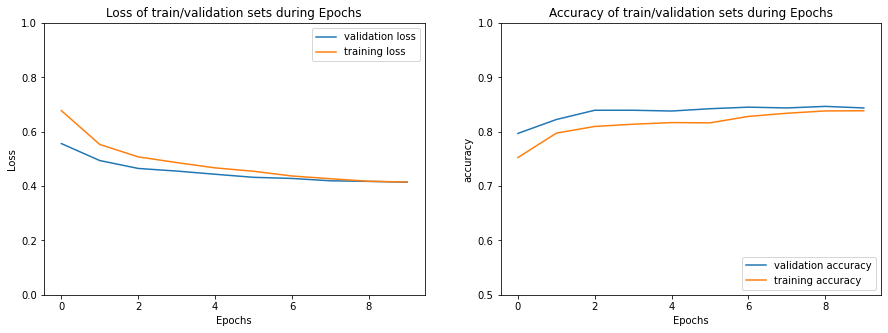

In [17]:
for i in range(len(history_per_fold)):
  print(f"--------------------FOLD {i+1} --------------------")
  plot_model(history_per_fold[i])

### Train the network with all the training set

In [18]:
model=reg_four_layer_model_config()
comp(model,lr=0.001)
history = model.fit(x_train, y_train, batch_size=64,epochs=10,validation_split=0.07, verbose=1)

Epoch 1/10
103/103 [==============================] - 1s 6ms/step - loss: 0.6266 - binary_accuracy: 0.7784 - val_loss: 0.5367 - val_binary_accuracy: 0.8036
Epoch 2/10
103/103 [==============================] - 0s 3ms/step - loss: 0.5493 - binary_accuracy: 0.7941 - val_loss: 0.4944 - val_binary_accuracy: 0.8300
Epoch 3/10
103/103 [==============================] - 0s 3ms/step - loss: 0.5054 - binary_accuracy: 0.8059 - val_loss: 0.4656 - val_binary_accuracy: 0.8401
Epoch 4/10
103/103 [==============================] - 0s 3ms/step - loss: 0.4810 - binary_accuracy: 0.8166 - val_loss: 0.4556 - val_binary_accuracy: 0.8401
Epoch 5/10
103/103 [==============================] - 0s 3ms/step - loss: 0.4661 - binary_accuracy: 0.8207 - val_loss: 0.4358 - val_binary_accuracy: 0.8482
Epoch 6/10
103/103 [==============================] - 1s 6ms/step - loss: 0.4450 - binary_accuracy: 0.8239 - val_loss: 0.4246 - val_binary_accuracy: 0.8522
Epoch 7/10
103/103 [==============================] - 1s 7ms/ste

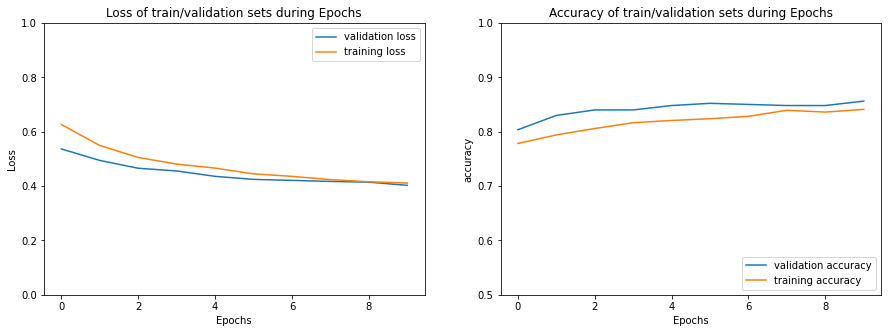

In [19]:
plot_model(history)

In [20]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 0s 7ms/step - loss: 0.4040 - binary_accuracy: 0.8610


[0.40398967266082764, 0.8609693646430969]

In [21]:
y_pred=np.squeeze(model.predict(x_test))
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.

In [22]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.88      0.96      0.92       617
     class 1       0.76      0.50      0.61       167

    accuracy                           0.86       784
   macro avg       0.82      0.73      0.76       784
weighted avg       0.85      0.86      0.85       784



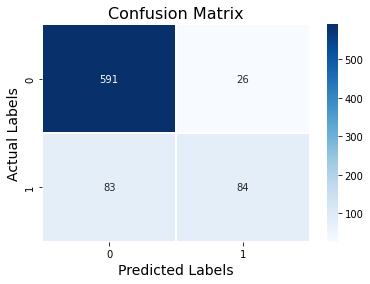

In [23]:
cm=pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, np.squeeze(model.predict(x_test)))
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

In [25]:
auc = roc_auc_score(y_test, np.squeeze(model.predict(x_test)))

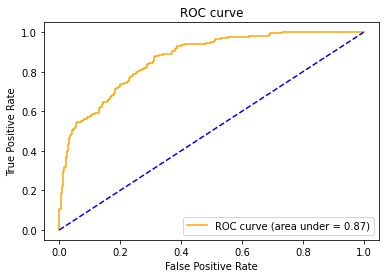

In [27]:
plt.plot(fpr,tpr, label=f'ROC curve (area under = {auc :.2f})',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

---------------
# Decision Tree
---------------


In [28]:
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=0.1,random_state=50)

# Building Decision Tree by CP criterion



In [31]:
tree = DecisionTreeClassifier(criterion='gini')
path =tree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.

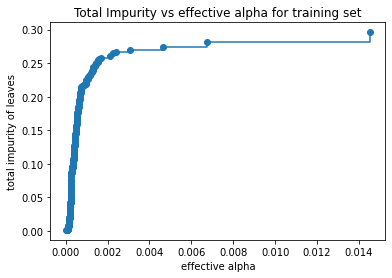

In [32]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

As you can see, greater alphas are corresponding to shallower trees with more impurities.

In [33]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(x_train, y_train)
    trees.append(tree)

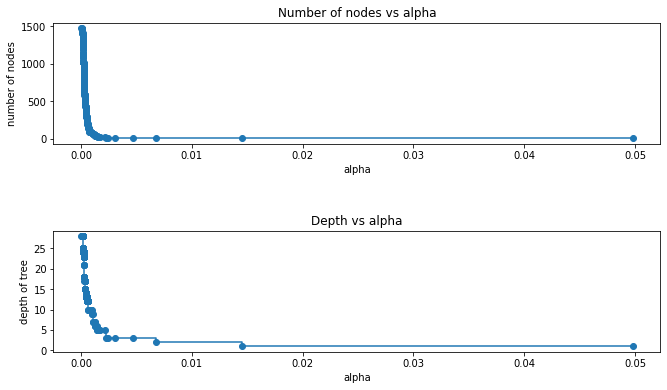

In [34]:
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
fig.set_size_inches(10, 6)
plt.show()

In the above graphs, we showed that lower alphas are corresponded to more complex trees with more nodes and depth.

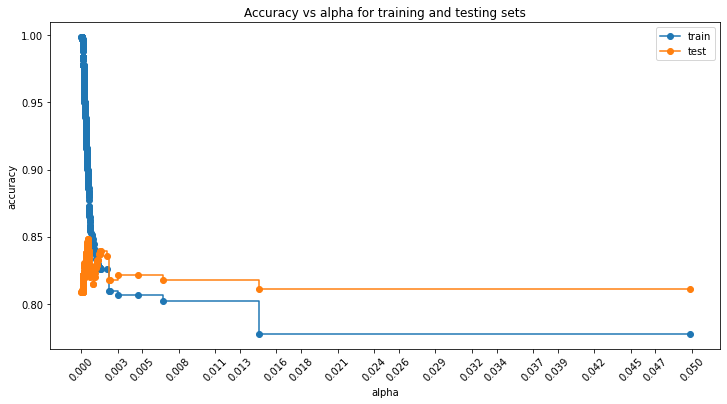

In [96]:
train_scores = [tree.score(x_train, y_train) for tree in trees]
test_scores = [tree.score(x_test, y_test) for tree in trees]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
plt.xticks(np.around(np.linspace(0,0.05,20),3),rotation=45)
ax.legend()
fig.set_size_inches(12, 6)
plt.show()

In [130]:
for i in range(402):
  if train_scores[i]<test_scores[i]:
    print(f' Train accuracy : {train_scores[i]:.4f} Test accuracy : {test_scores[i]:.4f} corresponds to CP : {ccp_alphas[i]:.6f}')

 Train accuracy : 0.8304 Test accuracy : 0.8316 corresponds to CP : 0.001312
 Train accuracy : 0.8293 Test accuracy : 0.8329 corresponds to CP : 0.001323
 Train accuracy : 0.8293 Test accuracy : 0.8329 corresponds to CP : 0.001377
 Train accuracy : 0.8284 Test accuracy : 0.8329 corresponds to CP : 0.001407
 Train accuracy : 0.8276 Test accuracy : 0.8367 corresponds to CP : 0.001466
 Train accuracy : 0.8276 Test accuracy : 0.8367 corresponds to CP : 0.001467
 Train accuracy : 0.8267 Test accuracy : 0.8367 corresponds to CP : 0.001524
 Train accuracy : 0.8267 Test accuracy : 0.8367 corresponds to CP : 0.001524
 Train accuracy : 0.8267 Test accuracy : 0.8367 corresponds to CP : 0.001540
 Train accuracy : 0.8260 Test accuracy : 0.8393 corresponds to CP : 0.001589
 Train accuracy : 0.8260 Test accuracy : 0.8393 corresponds to CP : 0.001670
 Train accuracy : 0.8259 Test accuracy : 0.8355 corresponds to CP : 0.002133
 Train accuracy : 0.8091 Test accuracy : 0.8176 corresponds to CP : 0.002261

We are going to choose the most suitable alpha for CP, acoording to above graph.

In [141]:
tree = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.001670)
tree.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00167)

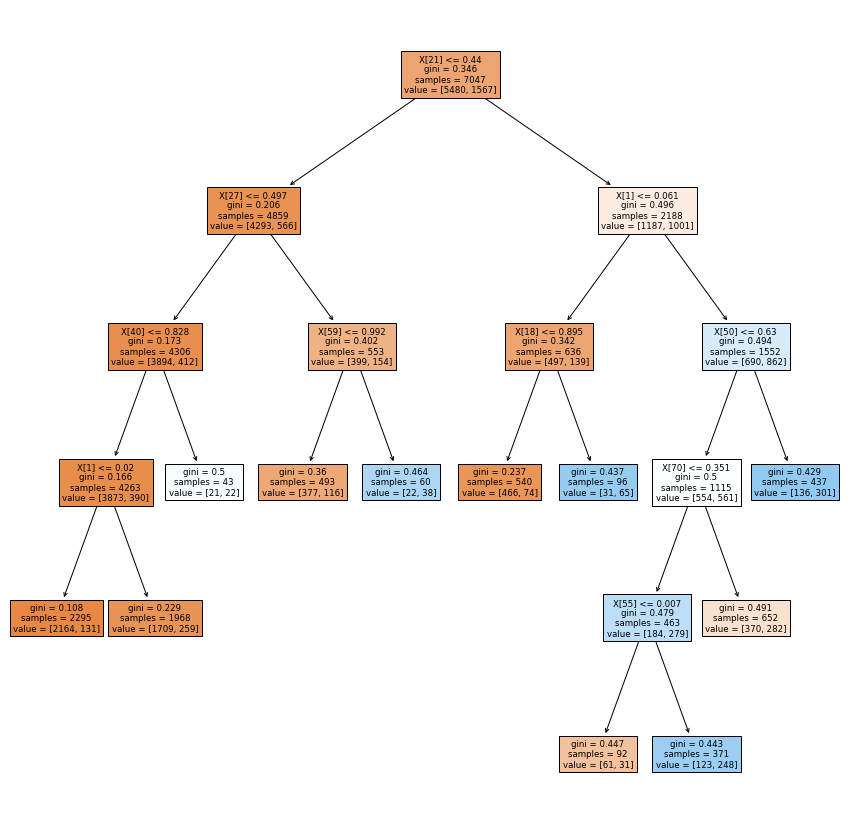

In [142]:
plt.figure(figsize=(15,15))
plot_tree(tree,filled=True)
plt.show()

In [143]:
y_pred=tree.predict(x_test)
accuracy_score(y_test,y_pred)*100

83.92857142857143

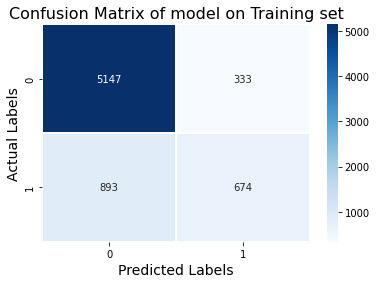

In [144]:
cm=pd.DataFrame(confusion_matrix(y_train, tree.predict(x_train)))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix of model on Training set', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [145]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.88      0.93      0.90       636
     class 1       0.60      0.45      0.51       148

    accuracy                           0.84       784
   macro avg       0.74      0.69      0.71       784
weighted avg       0.83      0.84      0.83       784



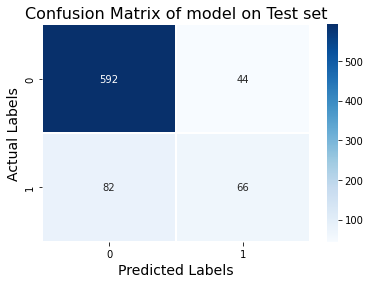

In [146]:
cm=pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix of model on Test set', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [147]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

In [149]:
auc = roc_auc_score(y_test, y_pred)

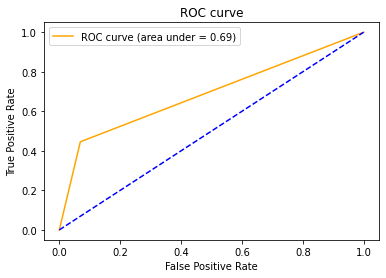

In [150]:
plt.plot(fpr,tpr, label=f'ROC curve (area under = {auc :.2f})',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# Building Decision Tree by modifying depth and number of leaf nodes

In [172]:
depth = []
for i in range(3,20):
    clf = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)

[(3, 0.8019044165054803), (4, 0.8109836395873631), (5, 0.80999194068343), (6, 0.8118351063829788), (7, 0.8162334784010316), (8, 0.8105587121212121), (9, 0.8155236540941327), (10, 0.8077202208252741), (11, 0.8065864764667957), (12, 0.8092799000644744), (13, 0.8027532640232108), (14, 0.8037449629271439), (15, 0.8019005883301096), (16, 0.8011915699548678), (17, 0.7999125564152161), (18, 0.7966495406189555), (19, 0.793385718891038)]


In [175]:
leaf_node = []
for i in range(3,20):
    clf = DecisionTreeClassifier(max_leaf_nodes=i)
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10, n_jobs=4)
    leaf_node.append((i,scores.mean()))
print(leaf_node)

[(3, 0.8013334139264991), (4, 0.8061597356544166), (5, 0.8061597356544166), (6, 0.8024715909090909), (7, 0.8060205109606706), (8, 0.8088573903932946), (9, 0.8111285058027079), (10, 0.8109866618310766), (11, 0.8111279013539653), (12, 0.810986057382334), (13, 0.8133988152804644), (14, 0.8129732833655705), (15, 0.8136825032237265), (16, 0.8135396518375242), (17, 0.8136810928433269), (18, 0.8125453336557061), (19, 0.8132551579626048)]


So, we should either choose max_leaf_nodes 9 with accuracy 81.11% or max_depth 7 with accuracy 81.62%
We'll go with max_depth parameter.

In [182]:
tree = DecisionTreeClassifier(max_leaf_nodes=9)
tree.fit(x_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=9)

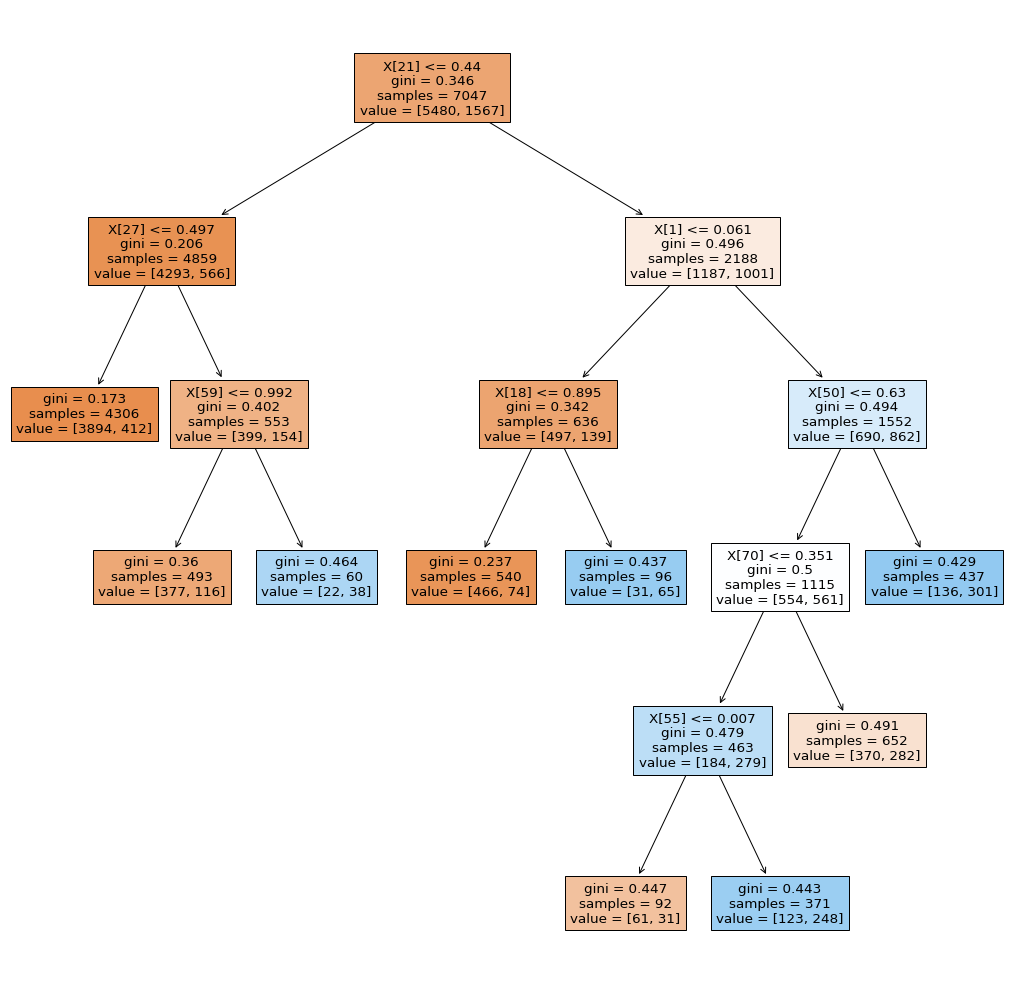

In [183]:
plt.figure(figsize=(18,18))
plot_tree(tree,filled=True)
plt.show()

In [184]:
y_pred=tree.predict(x_test)
accuracy_score(y_test,y_pred)*100

83.54591836734694

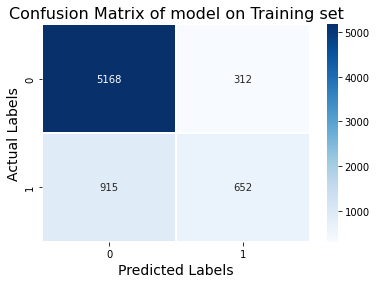

In [185]:
cm=pd.DataFrame(confusion_matrix(y_train, tree.predict(x_train)))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix of model on Training set', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [186]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.93      0.90       636
     class 1       0.59      0.42      0.49       148

    accuracy                           0.84       784
   macro avg       0.73      0.68      0.70       784
weighted avg       0.82      0.84      0.82       784



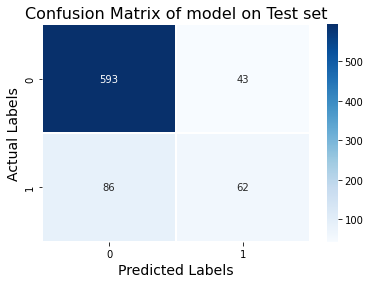

In [187]:
cm=pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix of model on Test set', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


In [188]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

In [189]:
auc = roc_auc_score(y_test, y_pred)

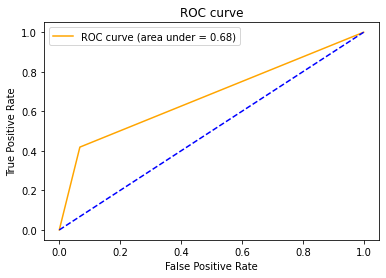

In [190]:
plt.plot(fpr,tpr, label=f'ROC curve (area under = {auc :.2f})',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()